<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_6_2_MLP_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 160 kB 29.7 MB/s 


In [ ]:
#@title Imports
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
from IPython.display import clear_output

#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import random

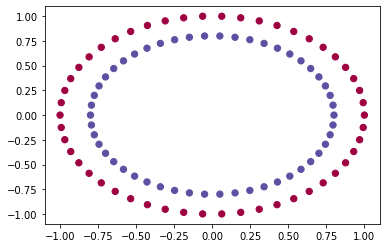

In [ ]:
#@title Dataset Parameters  { run: "auto" }
number_samples = 100 #@param {type:"slider", min:100, max:1000, step:25}
difficulty = 1 #@param {type:"slider", min:1, max:5, step:1}
problem = "circles" #@param ["classification", "blobs", "gaussian quantiles", "moons", "circles"]
number_features = 2
number_classes = 2 
middle_layer = 5 #@param {type:"slider", min:5, max:25, step:1}

def load_data(problem):  
  if problem == "classification":
    clusters = 1 if difficulty < 3 else 2
    informs = 1 if difficulty < 4 else 2
    data = sklearn.datasets.make_classification(
        n_samples = number_samples,
        n_features=number_features, 
        n_redundant=0, 
        class_sep=1/difficulty,
        n_informative=informs, 
        n_clusters_per_class=clusters)
    
  if problem == "blobs":
    data = sklearn.datasets.make_blobs(
        n_samples = number_samples,
        n_features=number_features, 
        centers=number_classes,
        cluster_std = difficulty)
  
  if problem == "gaussian quantiles":
    data = sklearn.datasets.make_gaussian_quantiles(mean=None, 
                                                  cov=difficulty,
                                                  n_samples=number_samples,
                                                  n_features=number_features,
                                                  n_classes=number_classes,
                                                  shuffle=True,
                                                  random_state=None)
    
  if problem == "moons":
    data = sklearn.datasets.make_moons(
        n_samples = number_samples)
    
  if problem == "circles":
    data = sklearn.datasets.make_circles(
        n_samples = number_samples)
    
  return data

data = load_data(problem)
X, Y = data


# Input Data
plt.figure("Input Data")
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)


In [ ]:
#@title Helper function to show prediction results
def show_predictions(model, X, Y, name=""):
    """ display the labeled data X and a surface of prediction of model """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_temp = np.c_[xx.flatten(), yy.flatten()]
    Z = model.predict(X_temp)
    plt.figure("Predictions " + name)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1],c=Y, s=40, cmap=plt.cm.Spectral)    

Logistic Regression accuracy :  0.5


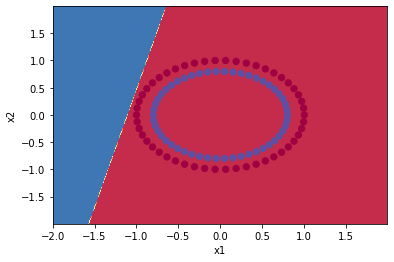

In [ ]:
#@title Logisitc Regression with SKLearn
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, Y)

show_predictions(clf, X, Y, "Logistic regression")
    
LR_predictions = clf.predict(X)
print("Logistic Regression accuracy : ", np.sum(LR_predictions == Y) / Y.shape[0])

21
[array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]]), array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]]), array([[1., 1., 1., 1., 1.]]), array([[1.]])]
Neural Network accuracy :  0.59


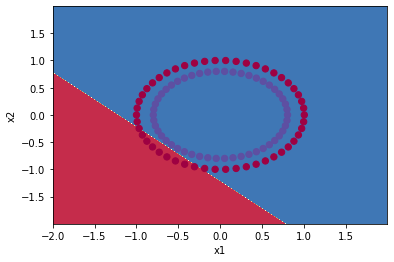

In [ ]:
#@title Neural Network Class (MLP) and Activation function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) 

## Neural Network
class Neural_Network:
    def __init__(self, n_in, n_hidden, n_out):
        # Network dimensions
        self.n_x = n_in
        self.n_h = n_hidden
        self.n_y = n_out
        
        # Parameters initialization
        self.W1 = np.random.randn(self.n_h, self.n_x) * 0.01
        self.b1 = np.zeros((self.n_h, 1))
        self.W2 = np.random.randn(self.n_y, self.n_h) * 0.01
        self.b2 = np.zeros((self.n_y, 1))
        self.parameters = [self.W1, self.b1, self.W2, self.b2]

    def forward(self, X):
        """ Forward computation """
        self.Z1 = self.W1.dot(X.T) + self.b1
        self.A1 = np.tanh(self.Z1)
        self.Z2 = self.W2.dot(self.A1) + self.b2
        self.A2 = sigmoid(self.Z2)

    def set_parameters(self, individual):
      """Sets model parameters """
      idx = 0
      for p in self.parameters:        
        size = p.size
        sh = p.shape
        t = individual[idx:idx+size]
        t = np.array(t)
        t = np.reshape(t, sh)
        p -= p
        p += t
        idx += size
    
    def predict(self, X):
        """ Compute predictions with just a forward pass """
        self.forward(X)
        return np.round(self.A2).astype(np.int)

nn = Neural_Network(2, middle_layer, 1)
number_of_genes = sum([p.size for p in nn.parameters])
print(number_of_genes)

individual = np.ones(number_of_genes)
nn.set_parameters(individual)
print(nn.parameters)

show_predictions(nn, X, Y, "Neural Network")

nn_predictions = nn.predict(X)
print("Neural Network accuracy : ", np.sum(nn_predictions == Y) / Y.shape[0])

In [ ]:
#@title Setting up the Creator
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
#@title DEAP Toolbox setup
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, -1, 1, number_of_genes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", tools.cxBlend, alpha=.5)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=.1, indpb=.25)

In [ ]:
#@title Evaluate function
def evaluate(individual):  
  nn.set_parameters(individual)
  nn_predictions = nn.predict(X)
  return 1/np.sum(nn_predictions == Y) / Y.shape[0], 

toolbox.register("evaluate", evaluate)   

In [ ]:
#@title Optimize the Weights { run: "auto" }
MU = 1000 #@param {type:"slider", min:5, max:1000, step:5}
NGEN = 100 #@param {type:"slider", min:100, max:1000, step:10}
RGEN = 10 #@param {type:"slider", min:1, max:100, step:1}
CXPB = .6
MUTPB = .3

random.seed(64)

pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Gen (50)
Current Neural Network accuracy :  0.72


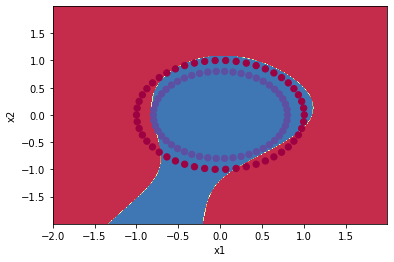

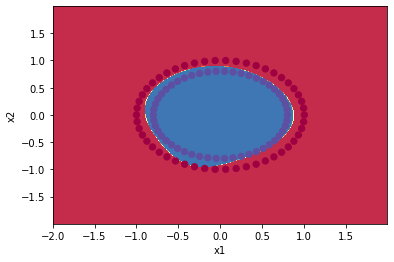

Best Neural Network accuracy :  1.0


In [ ]:
#@title Evolving the model
best = None
history = []

for g in range(NGEN):
  pop, logbook = algorithms.eaSimple(pop, toolbox, 
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)
  best = hof[0] 
  clear_output()
  print(f"Gen ({(g+1)*RGEN})")
  show_predictions(nn, X, Y, "Neural Network") 
  nn_predictions = nn.predict(X)
  print("Current Neural Network accuracy : ", np.sum(nn_predictions == Y) / Y.shape[0])
  plt.show()

  nn.set_parameters(best)
  show_predictions(nn, X, Y, "Best Neural Network")
  plt.show()
  nn_predictions = nn.predict(X)
  fitness = np.sum(nn_predictions == Y) / Y.shape[0]
  print("Best Neural Network accuracy : ", fitness)
  if fitness > .99999: #stop condition
    break